In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_profiling as pp

sns.set_theme(style = 'whitegrid', font_scale = 2)

In [3]:
def load_and_process(csv1,csv2):

    #Load Data and add columns for "daily gain", "daily volatility" and a blank column "industry" to be filled later to "df"
    
    df = (pd.read_csv(csv1)

            .drop(["volume"], axis =1 )

            .assign(
              daily_gain = lambda x: x["close"]-x["open"],
              daily_volatility = lambda x: x["high"]-x["low"])
         )

    # Load second data set, drop unwanted columns, name column to match other dataframe

    df_industry = (pd.read_csv(csv2)

                   .drop(["Security","SEC filings","Headquarters Location","Date first added","CIK","Founded\n"], axis =1)

                   .rename(columns={"Symbol\n":"Name"})

                  )

    # Cean ticker symbols to match "df"
    df_industry["Name"] = df_industry["Name"].map(lambda x: x.rstrip('\n'))

    #Join the dataframes so that the "GICS Sub-Industry" column from "df_industry" is in "df" and dropna values(stocks that were not presented on both dataframes)
    #Sort values by "Name"
    df2 = (df.join(df_industry.set_index("Name"), on="Name")

             .dropna()

             .sort_values("Name")

          )
    
    return df2

In [4]:
df = load_and_process("../data/raw/all_stocks_5yr.csv","../data/raw/List of stocks by industry.csv")
df

date   open    high     low  close Name  daily_gain  \
71611   2013-02-08  45.07  45.350  45.000  45.08    A        0.01   
72454   2016-06-15  45.11  45.380  44.900  44.94    A       -0.17   
72453   2016-06-14  44.70  44.945  44.560  44.91    A        0.21   
72452   2016-06-13  45.32  45.520  44.905  44.92    A       -0.40   
72451   2016-06-10  45.73  45.780  45.190  45.36    A       -0.37   
...            ...    ...     ...     ...    ...  ...         ...   
618197  2014-10-03  36.87  37.725  36.870  37.67  ZTS        0.80   
618196  2014-10-02  36.58  36.970  36.460  36.91  ZTS        0.33   
618195  2014-10-01  36.87  37.010  36.230  36.45  ZTS       -0.42   
618202  2014-10-10  37.02  37.300  36.640  36.68  ZTS       -0.34   
619039  2018-02-07  72.70  75.000  72.690  73.86  ZTS        1.16   

        daily_volatility  GICS Sector      GICS Sub-Industry  
71611              0.350  Health Care  Health Care Equipment  
72454              0.480  Health Care  Health Care Equipment  
72453              0.385  Health Care  Health Care Equipment  
72452              0.615  Health Care  Health Care Equipment  
72451              0.590  Health Care  Health Care Equipment  
...                  ...          ...                    ...  
618197             0.855  Health Care        Pharmaceuticals  
618196             0.510  Health Care        Pharmaceuticals  
618195             0.780  Health Care        Pharmaceuticals  
618202             0.660  Health Care        Pharmaceuticals  
619039             2.310  Health Care        Pharmaceuticals  

[533800 rows x 10 columns]

In [5]:
df.describe(include = np.number).T

count       mean        std     min     25%     50%  \
open              533800.0  82.419400  82.416793   1.620  41.030  63.410   
high              533800.0  83.159703  83.120747   1.690  41.425  63.970   
low               533800.0  81.669050  81.671904   1.610  40.650  62.865   
close             533800.0  82.441210  82.421750   1.620  41.050  63.430   
daily_gain        533800.0   0.021809   1.425181 -75.810  -0.360   0.025   
daily_volatility  533800.0   1.490653   1.918286  -0.255   0.610   0.990   

                    75%      max  
open              95.62  1477.39  
high              96.43  1498.00  
low               94.80  1450.04  
close             95.64  1450.89  
daily_gain         0.42    81.38  
daily_volatility   1.66   138.26

In [6]:
df.describe(exclude = np.number).T

count unique                    top   freq
date               533800   1259             2018-01-04    433
Name               533800    433                    HAL   1259
GICS Sector        533800     12            Industrials  74146
GICS Sub-Industry  533800    118  Health Care Equipment  20126

## Initial Observations

- The most common Sub-Industry of S&P 500 companies is "Health Care Equipment"
- The "Industrials" Sector is the most common sector
- There are only 433/500 companies in the dataset after combining two seperate sets which imples 67 companies have left the S&P 500 since the data set was published
- There is an extremely high range in minimum and maximum values across all categories. It is probably a good idea to normalize the "daily gain" and "daily_colatility" categories as percentages of the stocks opening or closing price '
- There were 1259 trading days in the five year period where the data was collected

## Potential Questions

- Which Sub-Industry/Sector is most/least volatile on a day to day basis?
- Which Company saw the biggest increase in share price over the 5 year period?
- Does one month see more volatility than others on average?
- Does one month see more growth/loss than others on average?


In [40]:
df.profile_report()

In [8]:
# I am going to scale the "daily volatility" and "daily gain" columns as a percentage of the average of the open and close price for that day.

df["daily_gain%"] = 100*df["daily_gain"]/((df["close"]+df["open"])/2)
df["volatility%"] = 100*df["daily_volatility"]/((df["close"]+df["open"])/2)

In [9]:
#I now will group "GICS Sector" and take the mean of the values
dgps = df.groupby(["GICS Sector"], as_index=False).mean().sort_values(["daily_gain%"], ascending = False)
dgps

GICS Sector        open        high         low       close  \
8     Information Technology   62.428967   63.003789   61.852749   62.456441   
7                Industrials   86.816645   87.554464   86.093927   86.855473   
3           Consumer Staples   70.392629   70.903634   69.889861   70.417371   
11                 Utilities   52.465960   52.862658   52.068242   52.486930   
6                Health Care  104.985527  106.042235  103.907810  105.014166   
5                 Financials   69.962561   70.521842   69.402436   69.984862   
2     Consumer Discretionary   99.099805  100.050983   98.130594   99.109393   
0     Communication Services  119.954501  120.996135  118.844492  119.962740   
1   Communication Services\n   49.001850   49.325505   48.649351   49.008095   
10               Real Estate   92.556953   93.335098   91.745677   92.570418   
9                  Materials   80.486912   81.237490   79.723985   80.502693   
4                     Energy   65.974798   66.726592   65.192856   65.973802   

    daily_gain  daily_volatility  daily_gain%  volatility%  
8     0.027475          1.151040     0.048605     1.954171  
7     0.038828          1.460537     0.043261     1.789626  
3     0.024742          1.013774     0.039030     1.484254  
11    0.020970          0.794416     0.036818     1.601923  
6     0.028639          2.134426     0.036646     1.949880  
5     0.022300          1.119406     0.034159     1.681589  
2     0.009588          1.920389     0.014907     2.022413  
0     0.008240          2.151643     0.014246     2.050894  
1     0.006245          0.676153     0.012809     1.382965  
10    0.013466          1.589421     0.012343     1.731031  
9     0.015782          1.513505     0.008010     2.098865  
4    -0.000996          1.533737    -0.007034     2.491874

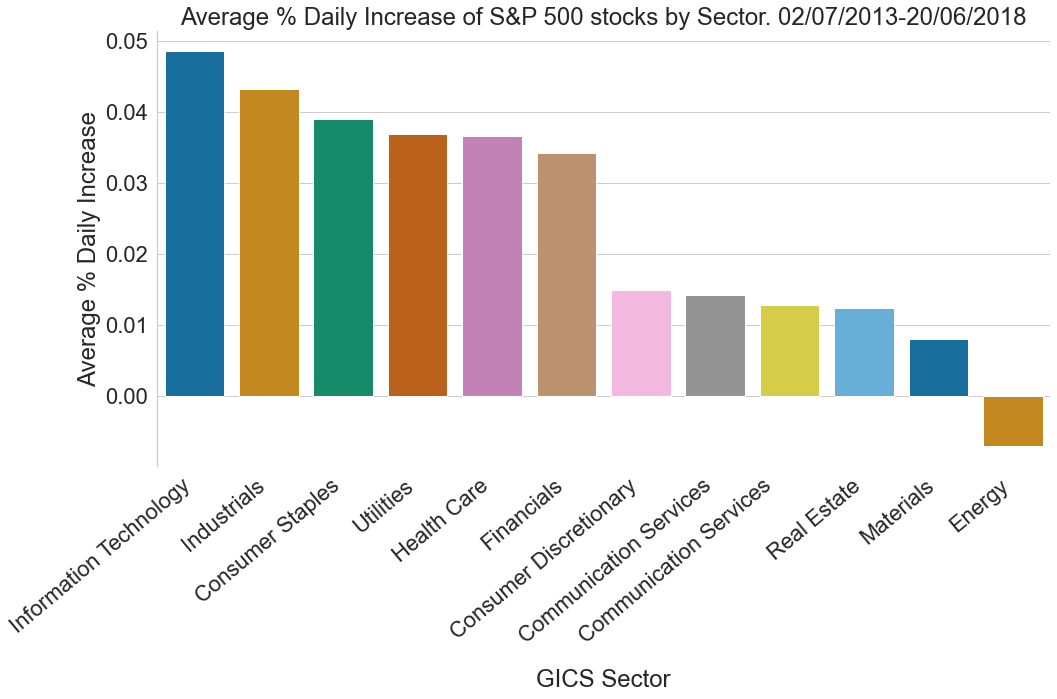

In [10]:
plt.figure(figsize=[16,8])
plot1 = sns.barplot(data = dgps, x="GICS Sector", y="daily_gain%", palette = "colorblind")
sns.despine(bottom =True)
plt.setp(plot1.get_xticklabels(),rotation = 40, horizontalalignment = 'right')
plt.ylabel("Average % Daily Increase")
plt.title("Average % Daily Increase of S&P 500 stocks by Sector. 02/07/2013-20/06/2018").set_position([.5,.5])
plt.show()

## Thoughts

The above is a good visualization of which sectors were the best performing on the 5 year period. This clearly shows that certain industries outperform others on average and that a weighted investment portfolio it Information Technology, Industrials and Consumer Staples for instance would have yielded greater returns over the 5 year period in question. 

The next step after identifying the best performing sectors would be to see if there is any data in my data set that **is highly correlated with an increase in Average % Daily increase.** 

Next I will explore correlation between volatility percentage and daily gain accross all companies in the dataset as well as across the GICS Sectors from the plot above. 

In [18]:
mu_i = df.groupby("Name", as_index = False).mean().sort_values(["daily_gain%"], ascending = False)
mu_i

Name       open       high        low      close  daily_gain  \
198   HPQ  15.912801  16.098331  15.754650  15.938468    0.025667   
197   HPE  17.997475  18.241246  17.797558  18.030878    0.033403   
210  INFO  33.794193  34.125879  33.485688  33.835076    0.040883   
54    BBY  37.854178  38.358002  37.388816  37.895449    0.041271   
296  NVDA  56.316546  57.071319  55.513103  56.369368    0.052822   
..    ...        ...        ...        ...        ...         ...   
42   APTV  89.547841  90.552320  88.538795  89.493864   -0.053977   
233   KMI  29.089816  29.362681  28.768499  29.065814   -0.024002   
156   FCX  20.785035  21.080104  20.462032  20.766370   -0.018665   
274   MRO  23.843816  24.156702  23.500501  23.824635   -0.019181   
386    UA  23.721156  24.055992  23.357280  23.684557   -0.036598   

     daily_volatility  daily_gain%  volatility%  
198          0.343680     0.175943     2.290666  
197          0.443688     0.174769     2.552435  
210          0.640191     0.130414     1.990414  
54           0.969186     0.111516     2.674776  
296          1.558215     0.109048     2.475782  
..                ...          ...          ...  
42           2.013525    -0.069904     2.239637  
233          0.594182    -0.080357     2.209407  
156          0.618072    -0.084946     3.725334  
274          0.656201    -0.089880     3.272047  
386          0.698711    -0.152634     3.042090  

[433 rows x 9 columns]

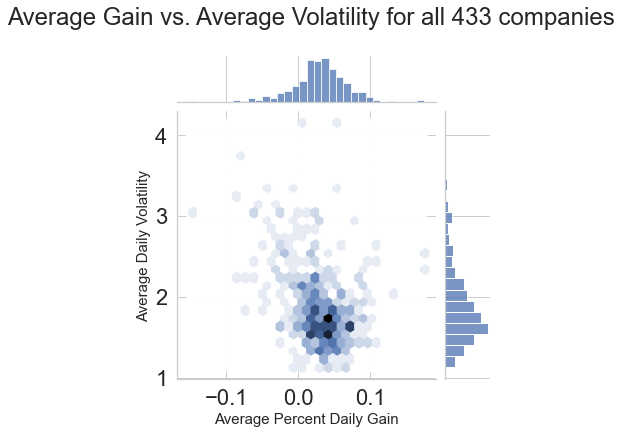

In [22]:
mui_plot = sns.jointplot(data = mu_i, x="daily_gain%", y="volatility%", kind="hex")
mui_plot.set_axis_labels("Average Percent Daily Gain", "Average Daily Volatility", fontsize=15)
plt.title("Average Gain vs. Average Volatility for all 433 companies", y=1.3, x=-3)
plt.show()

## Thoughts on the above plot

Unfortunately, this plot did not really show what I had hoped for. I was hoping to see a correlation between the average daily increase in stock price and the stocks average volatility. It appears that there is not a clear correlation, however it is interesting to see the distribution of points is most focused around a volatlity percentage between 1 and 2 percent and a daily gain percentage between 0 and 0.1%.

Below I will make a similar plot but seperated by Sector as this is more in line with my original research question. 

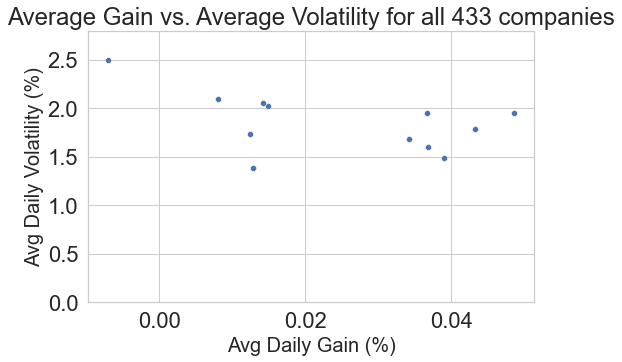

In [49]:
plt.figure(figsize=[8,5])
mui_plot2 = sns.scatterplot(data = dgps, x="daily_gain%", y="volatility%")
plt.ylim(0, 2.8)
plt.ylabel("Avg Daily Volatility (%)", fontsize = 20)
plt.xlabel("Avg Daily Gain (%)", fontsize = 20)
plt.title("Average Gain vs. Average Volatility for all 433 companies")
plt.show()

## Thoughts on the above plot

Again, it does not appear that there is any real correlation betweeen volatility and daily gain this time while grouping the stocks into their respective GICS Sectors. I do think that with only **11** different sectors there would not be enough data points to pull a meaningful relationship. 



## More Thoughts

I also want to see which sub industry performed the best over the 5 year period. There are **118** distinct values for this category and the increase in data points should allow potential for a better conclusion.

In [44]:
dfsu = df.groupby(["GICS Sub-Industry"], as_index=False).mean().sort_values(["daily_gain%"], ascending =False)
dfsu

GICS Sub-Industry        open        high         low  \
20          Computer & Electronics Retail   37.854178   38.358002   37.388816   
36                  Electronic Components   39.172779   39.474566   38.897032   
111                      Systems Software   51.026394   51.436007   50.630397   
80                    Managed Health Care  119.439258  120.662361  118.301279   
1                     Aerospace & Defense  151.617726  152.854561  150.448683   
..                                    ...         ...         ...         ...   
55                           Homebuilding   31.311304   31.684943   30.919686   
40   Fertilizers & Agricultural Chemicals   47.151631   47.676620   46.601428   
45                                   Gold   29.048356   29.459076   28.609101   
11               Automobile Manufacturers   24.341249   24.560840   24.092061   
26                                 Copper   20.785035   21.080104   20.462032   

          close  daily_gain  daily_volatility  daily_gain%  volatility%  
20    37.895449    0.041271          0.969186     0.111516     2.674776  
36    39.201432    0.028653          0.577534     0.083312     1.598012  
111   51.063081    0.036686          0.805610     0.082040     1.618455  
80   119.531385    0.092127          2.361082     0.081286     2.043722  
1    151.725727    0.108000          2.405878     0.077907     1.646917  
..          ...         ...               ...          ...          ...  
55    31.304676   -0.006628          0.765257    -0.024120     2.528015  
40    47.138421   -0.013209          1.075192    -0.025012     2.495018  
45    29.030659   -0.017697          0.849975    -0.056347     3.023303  
11    24.327812   -0.013437          0.468779    -0.058063     1.905772  
26    20.766370   -0.018665          0.618072    -0.084946     3.725334  

[118 rows x 9 columns]

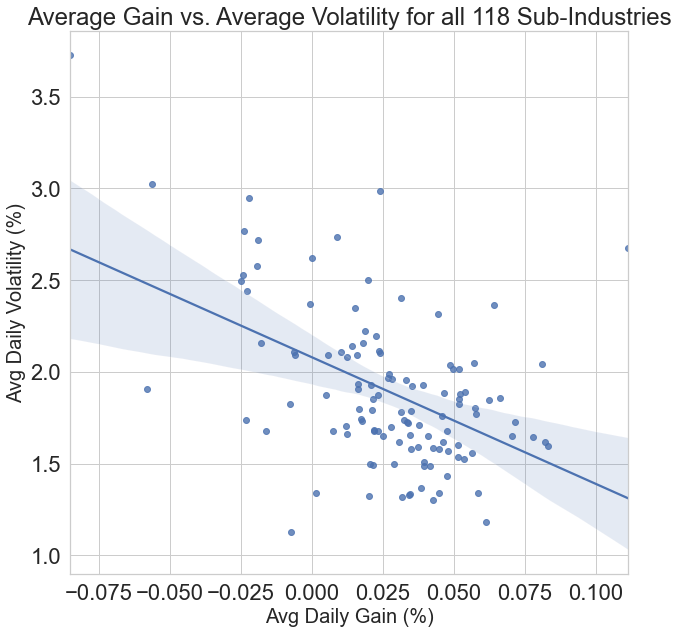

In [59]:
plt.figure(figsize = [10,10])
regplot = sns.regplot(x="daily_gain%", y="volatility%", data = dfsu, ci=95)
plt.ylabel("Avg Daily Volatility (%)", fontsize = 20)
plt.xlabel("Avg Daily Gain (%)", fontsize=20)
plt.title("Average Gain vs. Average Volatility for all 118 Sub-Industries")
plt.show()

## Perhaps a meaningful conclusion?

The above graph shows that there is a **negative correlation** between the average daily volatility % and average daily gain %. This means that on average, less volatile industries performed better than more volatile industries over the 5 year period. The above linear regression line is drawn with erro bars to represent a 95% confidence interval. I will now apply the same regression plot on the entire dataset to see if this holds true. 

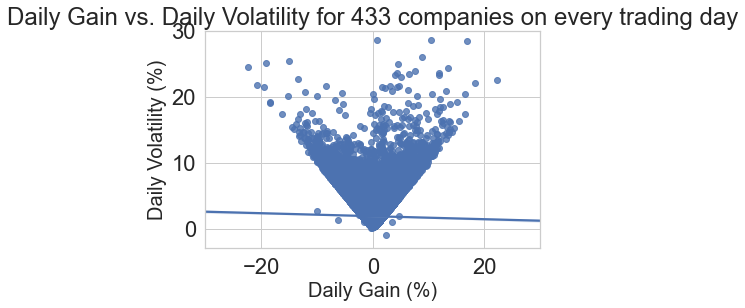

In [61]:
regplot = sns.regplot(x="daily_gain%", y="volatility%", data = df, ci=95)
plt.ylabel("Daily Volatility (%)", fontsize = 20)
plt.ylim(-3,30)
plt.xlim(-30,30)
plt.xlabel("Daily Gain (%)", fontsize=20)
plt.title("Daily Gain vs. Daily Volatility for 433 companies on every trading day")

plt.show()

## Thoughts on the above graph

Although the points on the above graph are extremely clustered, it does show that the line of regression does still have a negative slope. This is further evidence of a negative correlation between volatility and and stock performace. 

In [56]:
itdf = df[df["GICS Sector"] == "Information Technology"].groupby(["Name"], as_index=False).mean().sort_values(["daily_gain%"], ascending =False)
itdf

Name        open        high         low       close  daily_gain  \
25   HPQ   15.912801   16.098331   15.754650   15.938468    0.025667   
24   HPE   17.997475   18.241246   17.797558   18.030878    0.033403   
39  NVDA   56.316546   57.071319   55.513103   56.369368    0.052822   
20  FISV   85.183423   85.801402   84.630166   85.268783    0.085359   
28  INTU   99.011898   99.812090   98.251744   99.109798    0.097900   
1    ACN  101.022826  101.766440  100.348163  101.119079    0.096253   
38  NTAP   37.058345   37.458697   36.703894   37.091288    0.032943   
22   GLW   21.512188   21.711820   21.338398   21.529936    0.017748   
12  CDNS   22.582665   22.800383   22.375266   22.603098    0.020433   
27  INTC   31.804532   32.085517   31.538920   31.831531    0.026998   
5   ADSK   64.138877   64.874703   63.417575   64.194336    0.055459   
35  MSFT   51.026394   51.436007   50.630397   51.063081    0.036686   
19   FIS   65.905919   66.364016   65.466530   65.956390    0.050471   
10   APH   56.833370   57.237312   56.455667   56.872927    0.039557   
2   ADBE   90.387609   91.189876   89.578621   90.458156    0.070547   
45  SNPS   51.641422   52.043325   51.259464   51.676725    0.035303   
49   TXN   58.826187   59.313848   58.355130   58.868927    0.042740   
30  JNPR   24.612486   24.873455   24.374734   24.629051    0.016565   
29    IT   86.713249   87.415296   86.018136   86.766259    0.053010   
14  CSCO   27.725160   27.946371   27.522249   27.743813    0.018653   
41  PAYX   49.928316   50.278052   49.574841   49.959313    0.030997   
9   ANSS   93.536255   94.360107   92.745848   93.600523    0.064268   
17   DXC   85.887465   86.648435   85.207052   85.932419    0.044953   
23   GPN   56.967212   57.484427   56.447291   56.999567    0.032355   
44  QRVO   62.193028   63.198839   61.150868   62.221921    0.028892   
4    ADP   86.960322   87.552852   86.349654   87.009401    0.049079   
51  VRSN   71.546700   72.190096   70.966046   71.583067    0.036367   
36   MSI   70.368499   70.913413   69.867107   70.403900    0.035401   
21  FLIR   32.934047   33.245052   32.631267   32.951234    0.017187   
53    WU   18.512014   18.681904   18.355131   18.520481    0.008467   
40  ORCL   40.368928   40.681892   40.087095   40.386626    0.017698   
31  KLAC   72.363145   73.042317   71.673582   72.390903    0.027758   
18  FFIV  113.237671  114.436184  112.082159  113.290639    0.052969   
54  XLNX   49.819316   50.270837   49.359505   49.833474    0.014158   
48   TEL   64.143787   64.648160   63.645827   64.163058    0.019271   
13   CRM   69.087156   69.827704   68.336548   69.109686    0.022530   
33    MA   93.222557   93.936343   92.515966   93.253779    0.031222   
7   AMAT   25.838797   26.114575   25.538445   25.838925    0.000129   
6   AKAM   56.606090   57.218039   56.009504   56.625419    0.019329   
43  QCOM   63.922928   64.458449   63.392769   63.940961    0.018033   
16  CTXS   73.027264   73.742028   72.278194   73.046064    0.018801   
34  MCHP   54.416224   54.915822   53.881950   54.424015    0.007791   
46   STX   44.428280   45.033336   43.813061   44.437953    0.009673   
26   IBM  167.230871  168.362928  166.156247  167.261926    0.031055   
11  AVGO  130.748169  132.201614  129.088254  130.745677   -0.002492   
50     V   71.041770   71.555398   70.513758   71.051984    0.010214   
3    ADI   60.928583   61.470247   60.341293   60.931932    0.003350   
15  CTSH   55.385057   55.878179   54.872304   55.393480    0.008423   
0   AAPL  109.055429  109.951118  108.141589  109.066698    0.011270   
32  LRCX   89.439893   90.396604   88.378046   89.427689   -0.012204   
8    AMD    5.604315    5.717247    5.486633    5.601863   -0.002453   
47  SWKS   68.004043   68.874966   67.025150   68.007072    0.003029   
52   WDC   75.958892   76.923652   74.956465   75.954726   -0.004166   
55   XRX   40.488308   40.904809   40.057713   40.486807   -0.001501   
42  PYPL   46.173595   46.659586   45.617995

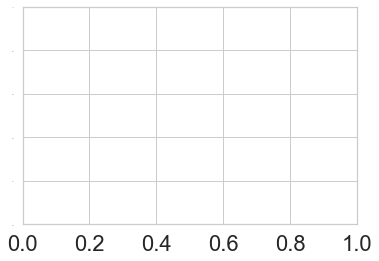

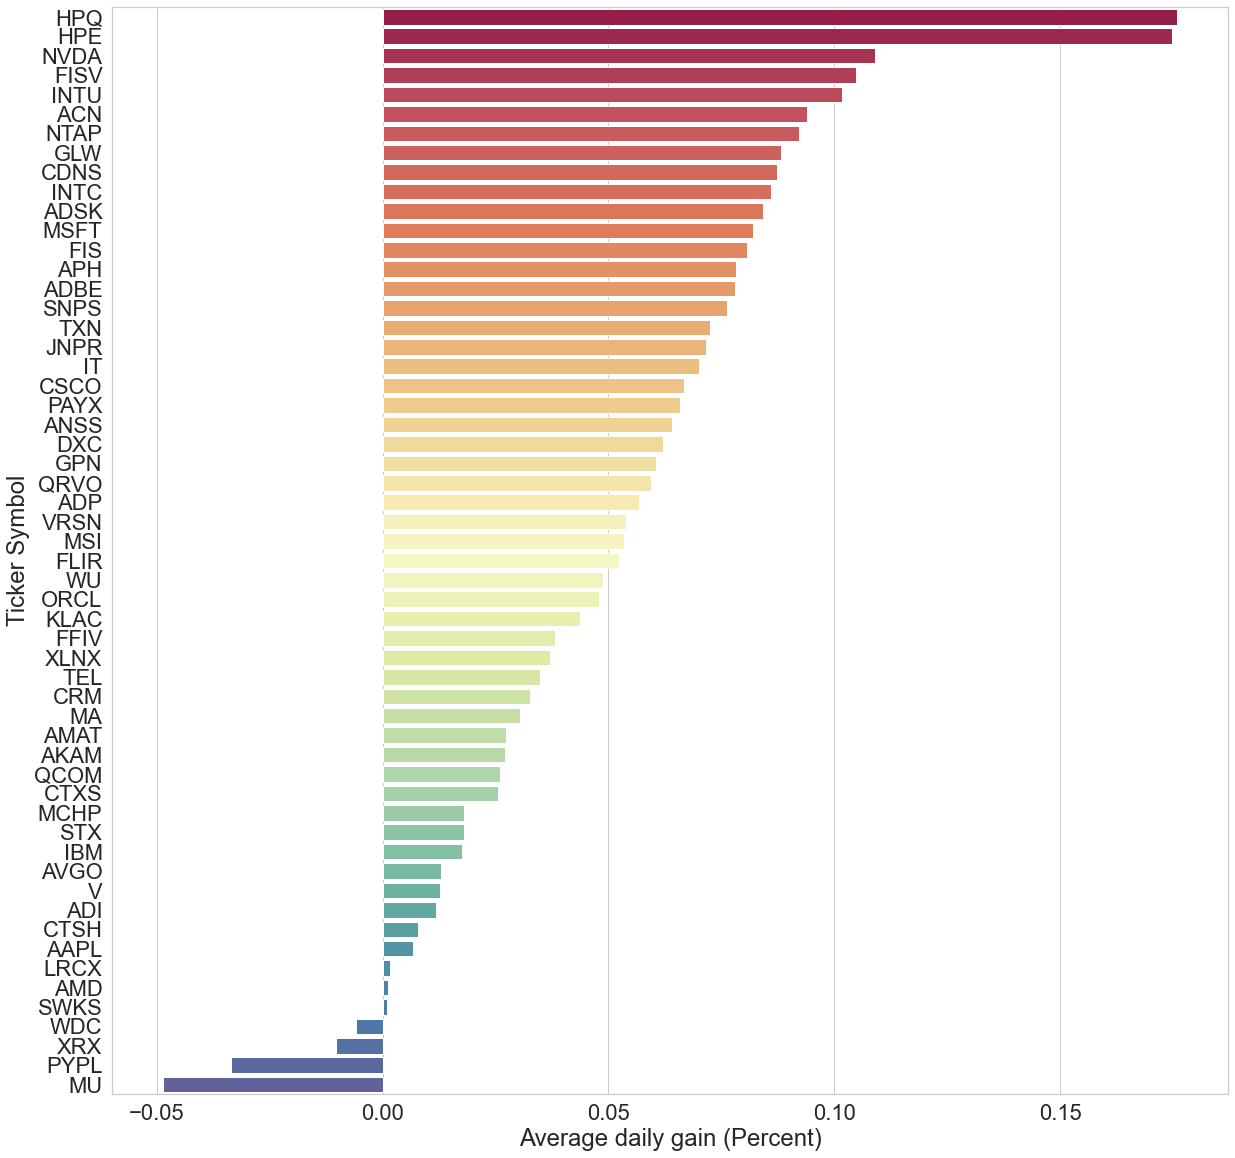

In [14]:
fig,ax = plt.subplots()
ax.tick_params(axis="y", labelsize = .5)
plt.figure(figsize=[20,20])
itplot = sns.barplot(data = itdf, x="daily_gain%", y="Name", palette = "Spectral")
plt.xlabel("Average daily gain (Percent)")
plt.ylabel("Ticker Symbol")
plt.show()